# Quantum Simulation via Superconducting Quantum Hardware

In [80]:
from qiskit import *
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import warnings
warnings.filterwarnings('ignore')

In [81]:
from qiskit import IBMQ
IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-04-07 13:25:09,217: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-04-07 13:25:09,787: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [82]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_santiago')
properties = backend.properties()

The Hamiltonian we consider 

$H=V\sum_{\left\langle i,j\right\rangle }Z_{i}Z_{j}+\Omega\sum_{i}X_{i}+h\sum_{i}Z_{i}$

In [83]:
def h_Z(qc,h,dt):
    for i in range(5):
        qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt):
    for i in range(5):
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt):
    #for i in range(5):
    qc.cx(0,1)
    
    qc.rz(-2*V,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V,4)
    
    qc.cx(3,4)
    

In [84]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    Trotter_circuits = []
    dt=T/n
    for i in range(n):
        Trotter_circuit = QuantumCircuit(5)
        Trotter_circuit.x(0)
        Trotter_circuit.x(2)
        Trotter_circuit.x(4)
        for k in range(i):
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
        Trotter_circuit.measure_all()
        Trotter_circuits.append(Trotter_circuit)
    return Trotter_circuits
    
    

In [85]:
Omega = 1
h = 2
V = 0.1
T = 1.5 # Total time 
n = 75
Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

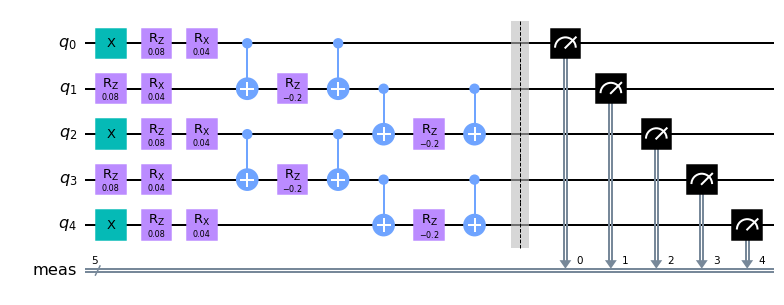

In [86]:
Trotter_circuit[1].draw(output = "mpl")

In [87]:
qr = QuantumRegister(5)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')



In [88]:
shots = 8192
il = [0,1,2,3,4]
Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [89]:
#for job in all_jobs:
job_monitor(Trotter_result)
    #try:
        #if job.error_message() is not None:
            #print(job.error_message())
    #except:
        #pass

Job Status: job has successfully run


In [92]:
result_counts = Trotter_mit.result()#.get_counts(25)

results = Trotter_result.result()

TypeError: reduce() arg 2 must support iteration

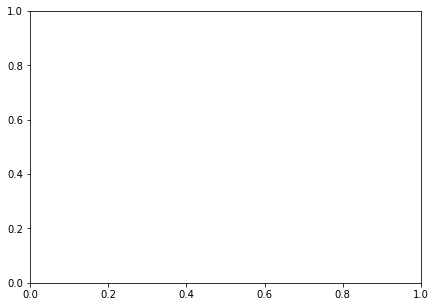

In [91]:
plot_histogram(result_counts, color='midnightblue')

In [93]:
cal_results = Trotter_mit.result()

In [94]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.8927002  0.02990723 0.07995605 ... 0.         0.         0.        ]
 [0.01525879 0.91491699 0.00134277 ... 0.         0.         0.        ]
 [0.05432129 0.00195312 0.88757324 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.88208008 0.00183105 0.07531738]
 [0.         0.         0.         ... 0.00170898 0.86962891 0.02758789]
 [0.         0.         0.         ... 0.04162598 0.01171875 0.85473633]]


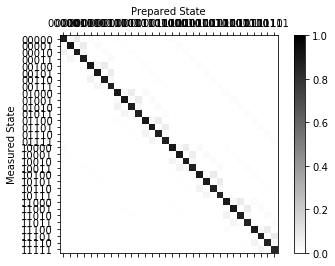

In [95]:
meas_fitter.plot_calibration()

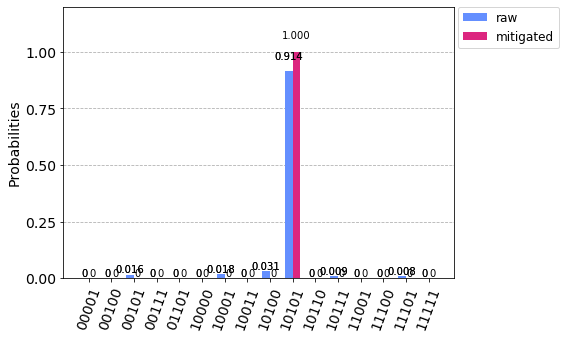

In [96]:
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

Result_nomit = results.get_counts(0) 
mitigated_counts = meas_fitter.filter.apply(results).get_counts(0)
plot_histogram([Result_nomit, mitigated_counts], legend=['raw', 'mitigated'])

In [97]:
tot=np.zeros(5)

for i in range(2**5):
    n=2**5
    if i in Result_nomit.int_outcomes():
        a=bin(n+i)[3:]
        c= ' '
        tot+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[i]
tot/8192

array([ 0.96582031, -0.98168945,  0.95898438, -0.98022461,  0.93286133])

In [98]:
Sz_nomit = []
Sz_mit = []
for i in range(75):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/8192)
    Sz_mit.append(tot_mit/8192)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)

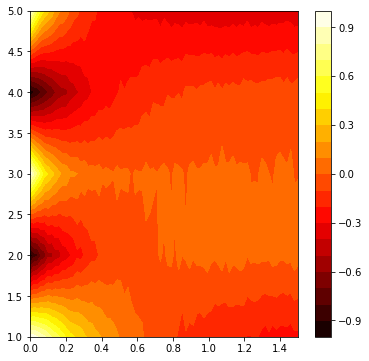

In [99]:
t=np.linspace(0,1.5,75)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_nomit), 20, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(1e6,1e10)
plt.show()


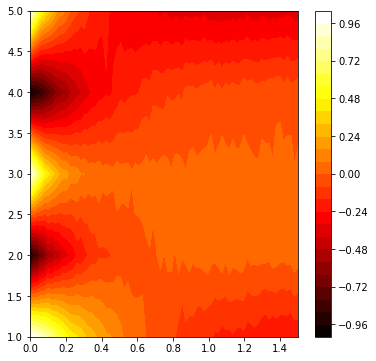

In [100]:
t=np.linspace(0,1.5,75)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_mit), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(1e6,1e10)
plt.show()

# Classical simulation

In [ ]:
def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z



In [ ]:
L=5

H0=0

for i in range(L):
    H0=H0+spin_x(i,L)+spin_z(i,L)


V=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V=V+np.dot(n_f,n_b)


